### Dataloaders & Co.


In [ ]:
import os
import time
import clip
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np

# Seeding
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class ImageTransform:
    """
    Custom transform for TPT.
    """

    def __init__(self, model_transform, custom_transform=None, n_views=63):
        if custom_transform is not None:
            self.model_transform = model_transform
            self.custom_transform = torchvision.transforms.Compose(
                [
                    custom_transform,
                    model_transform,
                ]
            )
        else:
            self.model_transform = model_transform
            self.custom_transform = None

        self.n_views = n_views

    def __call__(self, image: Image.Image):
        """
        Apply the model transform and custom transform to the image.
        """

        if self.custom_transform is not None:
            views = [self.custom_transform(image) for _ in range(self.n_views)]
            image = self.model_transform(image)
            views.append(image)
            return torch.stack(views, dim=0)
        else:
            return self.model_transform(image)


class ImageNetADataset(Dataset):
    """
    Custom Dataset class for the ImageNet-A dataset.

    Set the `transform` parameter so that images work with your model.
    Example usage:
    ```python
        model, transform = clip.load("ViT-B/32")
        dataset = ImageNetADataset(<path>, transform=transform)
    ```
    ----

    The dataset is organized into subdirectories, each named with a class code (e.g., "n01614925").
    Each subdirectory contains images belonging to that class. The dataset also includes a README.txt file that maps class codes to human-readable names.

    The dataset is expected to be structured as follows:
    ```
    datasets/imagenet-a/
        n01440764/
            image1.jpg
            image2.jpg
            ...
        n01614925/
            image1.jpg
            image2.jpg
            ...
        ...
        README.txt
    ```

    """

    def __init__(
        self, root_dir="datasets/imagenet-a", transform: ImageTransform = None
    ):
        """
        Args:
            root_dir (str): Root directory of the ImageNet-A dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.__download_if_needed()

        # Load mapping from class codes (e.g., "n01614925") to human-readable names
        readme_path = os.path.join(root_dir, "README.txt")
        self.class_code_to_label = self._load_class_mapping(readme_path)

        # Filter valid class directories that match the mapping
        self.class_codes = sorted(
            [
                d
                for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
                and d in self.class_code_to_label
            ]
        )

        # Map class codes to indices
        self.class_code_to_idx = {
            code: idx for idx, code in enumerate(self.class_codes)
        }

        # Collect all image file paths and corresponding labels
        self.samples = self._gather_samples()

        # Inverse mapping from label index to class name
        self.idx_to_label = {
            idx: self.class_code_to_label[code]
            for code, idx in self.class_code_to_idx.items()
        }

    def __download_if_needed(self):
        """
        Check if the dataset is already downloaded. If not, download it.
        """
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(
                f"Dataset not found at {self.root_dir}. Please download it first."
            )

    def _load_class_mapping(self, readme_path):
        """
        Load class code to human-readable name mapping from README.txt.
        Skips header lines and parses lines in format: 'n01440764 tench'.
        """
        mapping = {}
        with open(readme_path, "r") as file:
            lines = file.readlines()[12:]  # Skip first 12 header lines
            for line in lines:
                parts = line.strip().split(" ", 1)
                if len(parts) == 2:
                    code, name = parts
                    mapping[code] = name
        return mapping

    def _gather_samples(self):
        """
        Walk through each class directory to gather image paths and corresponding labels.
        """
        samples = []
        for class_code in self.class_codes:
            class_dir = os.path.join(self.root_dir, class_code)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(class_dir, filename)
                    label = self.class_code_to_idx[class_code]
                    samples.append((image_path, label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load image and return dictionary containing image, label index, and class name.

        Returns:
            image (tensor)
            label (tensor)
        """
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

    def get_class_name(self, idx):
        """
        Get human-readable class name for a given index.
        """
        return self.idx_to_label[idx]


def ResnetA(
    model_transform,
    custom_transform=None,
    root_dir="datasets/imagenet-a",
    n_views=63,
    num_workers=1,
):
    """
    Create a DataLoader for the ImageNet-A dataset. Defaults to 1 element per batch.
    Non modifiable. No shuffling.
    Args:
        root_dir (str): Root directory of the ImageNet-A dataset.
        transform (callable, optional): Optional transform to be applied on a sample.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        dataloader (DataLoader): DataLoader for the ImageNet-A dataset.
        dataset (ImageNetADataset): The underlying dataset object.

    Example usage:
    ```python
        model, transform = clip.load("ViT-B/32")
        dataloader, dataset = resneta_dataloader(root_dir=<path>, transform=transform)
    ```
    """
    transform = ImageTransform(
        model_transform=model_transform,
        custom_transform=custom_transform,
        n_views=n_views,
    )

    def collate_rn(batch):
        """
        Custom collate function to handle the batch of images and labels.
        """

        images = batch[0][0]

        if images.ndim == 3:
            images = images.unsqueeze(0)

        labels = batch[0][1]

        return images, labels

    dataset = ImageNetADataset(root_dir=root_dir, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_rn,
        # pin_memory=True,
    )

    return dataloader, dataset

# Baseline Pure - ViT-B/32

Here we will use the ViT-B/32 model from HuggingFace. The dataset will be created passing the transform given by the CLIP model. The dataloader will be straight forward.


In [5]:
model, model_transform = clip.load("ViT-B/32", device=device)

model.eval()

dataloader, dataset = ResnetA(
    model_transform=model_transform,
    root_dir="datasets/imagenet-a",
    num_workers=4,
)

In [7]:
correct = 0

# transform = ImageTransform(
#     model_transform=model_transform,
# )

prompt = torch.cat(
    [clip.tokenize(f"a photo of a {c}") for c in dataset.class_code_to_label.values()]
).to(device)

with torch.no_grad():
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

start = time.time()

for image, label in tqdm(dataloader):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate logits and predict
        logits = (image_features @ text_features.T).softmax(dim=-1)
        # logits = torch.nn.functional.cosine_similarity(
        #     image_features.unsqueeze(1), text_features.unsqueeze(0), dim=-1
        # )

        pred_class = logits.argmax(dim=-1)

        correct += int((pred_class == label).max().item())

end = time.time()

accuracy = correct / len(dataset)
latency = (end - start) / len(dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Latency: {latency * 1000:.2f} ms")

100%|██████████| 7500/7500 [00:27<00:00, 272.74it/s]

Accuracy: 29.84%
Latency: 3.67 ms


# Baseline TPT - ViT-B/32

Reimplementing from scratch TPT.

- prompt: `a photo of a` (4 tokens)
- Augmentation: AugMix, 63 images, random resized crops -> comapring to the original paper code they actually perform: _autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y, translate_x, translate_y_, so this is performed with AugMix.
- select top $10\%$ ($\rho=0.1$) confident samples (lowest $10\%$ self-entropy)
- compute entropy of the averaged probability of th eselected predictions (marginal entropy)
- optimize prompt ot minimize marginal entropy for 1 step, using AdamW with learning rate $5e-3$ (0.005)


In [9]:
dataloader, dataset = ResnetA(
    model_transform=model_transform,
    custom_transform=torchvision.transforms.AugMix(),
    root_dir="datasets/imagenet-a",
    num_workers=1,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


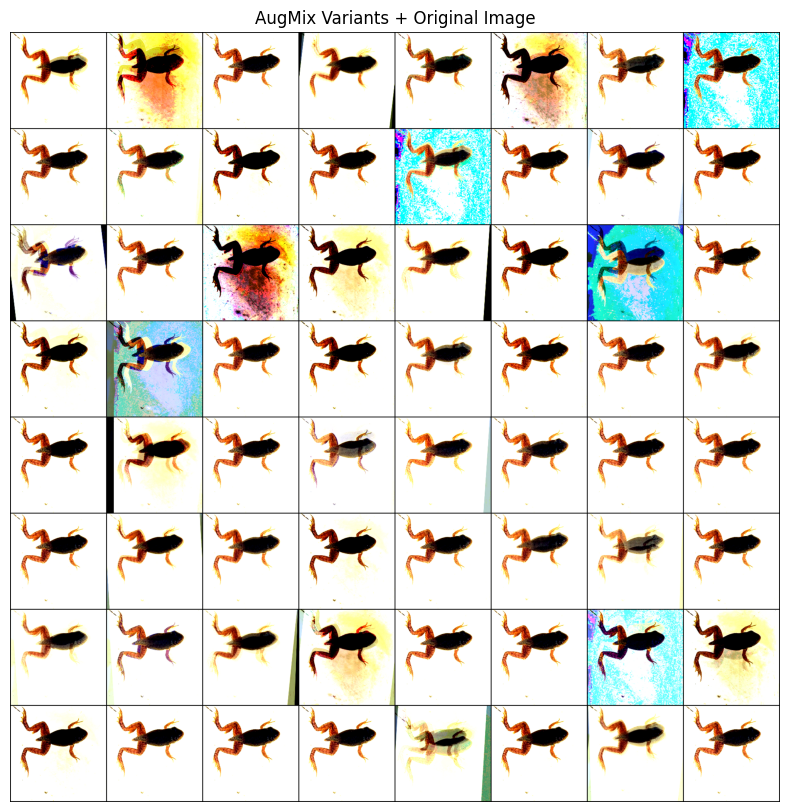

In [10]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images = dataset[666][0]

# Create a grid — 8x8 layout by default (you can change nrow)
grid = make_grid(images, nrow=8, padding=2)

grid_np = grid.permute(1, 2, 0).cpu().numpy()

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis("off")
plt.title("AugMix Variants + Original Image")
plt.show()

In [ ]:
correct = 0

prompt = torch.cat(
    [clip.tokenize(f"a photo of a {c}") for c in dataset.class_code_to_label.values()]
).to(device)


start = time.time()

logit_scale = torch.Tensor(torch.ones([]) * np.log(1 / 0.07)).exp()

for image, label in tqdm(dataloader):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        text_features = model.encode_text(prompt)
        image_features = model.encode_image(image)

        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        # https://discuss.pytorch.org/t/difference-between-tensor-t-and-tensor-t/165640/7
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        break

# def select_confident_samples(logits, top):
#     batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
#     idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * top)]
#     return logits[idx], idx

end = time.time()

accuracy = correct / len(dataset)
latency = (end - start) / len(dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Latency: {latency * 1000:.2f} ms")

  0%|          | 0/7500 [00:01<?, ?it/s]

Accuracy: 0.00%
Latency: 0.23 ms
